In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from slsim.Observations.roman_speclite import configure_roman_filters
from slsim.Observations.roman_speclite import filter_names
import speclite.filters
import matplotlib.patches as mpatches
import scipy
from phrosty import plotting

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs
from mejiro.instruments.roman import Roman

In [2]:
save_dir = os.path.join(config.machine.data_dir, 'output', 'lowest_detectable_subhalo_mass')
results = util.unpickle_all(save_dir, 'results_', '.pkl')

In [3]:
pprint(results[0].keys())

dict_keys(['1_511_511', '1_511_1533', '1_511_2555', '1_511_3577', '1_1533_511', '1_1533_1533', '1_1533_2555', '1_1533_3577', '1_2555_511', '1_2555_1533', '1_2555_2555', '1_2555_3577', '1_3577_511', '1_3577_1533', '1_3577_2555', '1_3577_3577', '2_511_511', '2_511_1533', '2_511_2555', '2_511_3577', '2_1533_511', '2_1533_1533', '2_1533_2555', '2_1533_3577', '2_2555_511', '2_2555_1533', '2_2555_2555', '2_2555_3577', '2_3577_511', '2_3577_1533', '2_3577_2555', '2_3577_3577', '3_511_511', '3_511_1533', '3_511_2555', '3_511_3577', '3_1533_511', '3_1533_1533', '3_1533_2555', '3_1533_3577', '3_2555_511', '3_2555_1533', '3_2555_2555', '3_2555_3577', '3_3577_511', '3_3577_1533', '3_3577_2555', '3_3577_3577', '4_511_511', '4_511_1533', '4_511_2555', '4_511_3577', '4_1533_511', '4_1533_1533', '4_1533_2555', '4_1533_3577', '4_2555_511', '4_2555_1533', '4_2555_2555', '4_2555_3577', '4_3577_511', '4_3577_1533', '4_3577_2555', '4_3577_3577', '5_511_511', '5_511_1533', '5_511_2555', '5_511_3577', '5_153

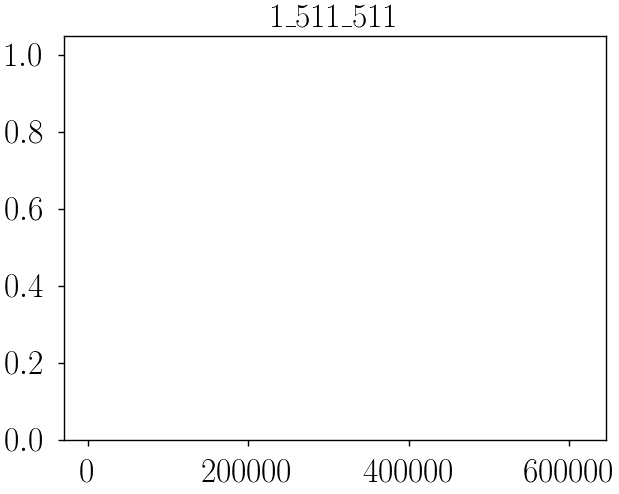

In [4]:
sample_position_key = list(results[0].keys())[0]
sample_results = results[0][sample_position_key]

mass_list, median_list, maxes, mins = [], [], [], []
for mass, chi_squared_list in sample_results.items():
    mass_list.append(mass)
    median_list.append(np.median(chi_squared_list))
    maxes.append(np.max(chi_squared_list))
    mins.append(np.min(chi_squared_list))
    if all(v == 0 for v in chi_squared_list):
        plt.axvline(0, label=f'{float(mass):.0e} M$_\odot$')
    else:
        plt.hist(chi_squared_list, label=f'{float(mass):.0e} M$_\odot$', alpha=0.5, bins=5)

uplims = np.array(maxes) - np.array(median_list)
lolims = np.array(median_list) - np.array(mins)

# plt.xscale('log')
plt.title(sample_position_key)
# plt.legend()
plt.savefig(os.path.join(figure_dir, 'ldsm_01_histogram.png'))
plt.show()

In [5]:
from scipy.stats import chi2

pixels = 42 ** 2
df = pixels - 3  # 3 dof: subhalo x, subhalo y, subhalo mass

rv = chi2(df)

pval_threshold = 0.001  # three sigma

chi2_list = np.linspace(1950, 1951, 100)
for chi in chi2_list:
    pval = rv.sf(chi)
    if pval < pval_threshold:
        print(f'chi2: {chi:.2f}, pval: {pval:.2e}')
        break

chi2: 1950.11, pval: 1.00e-03


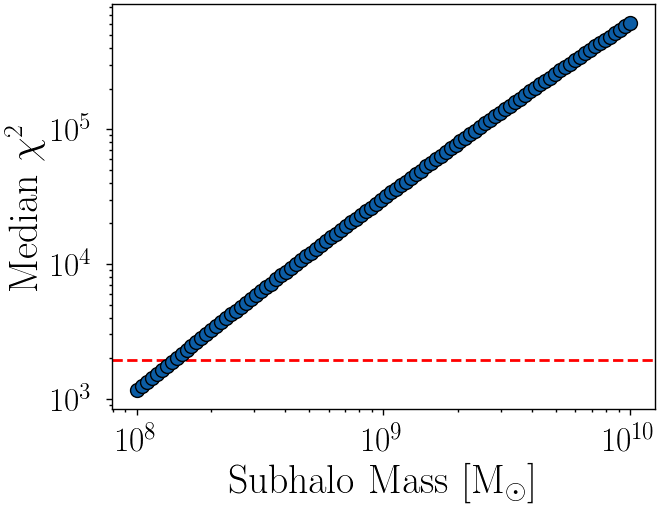

In [6]:
mass_list = [float(mass) for mass in mass_list]
plt.errorbar(mass_list, median_list, yerr=[uplims, lolims], fmt='o')
plt.axhline(1950.11, color='r', linestyle='--', label=f'3$\sigma$')
plt.xlabel('Subhalo Mass [M$_\odot$]')
plt.ylabel('Median $\chi^2$')
plt.xscale('log')
plt.yscale('log')
plt.savefig(os.path.join(figure_dir, 'ldsm_02_errorbar.png'))
plt.show()

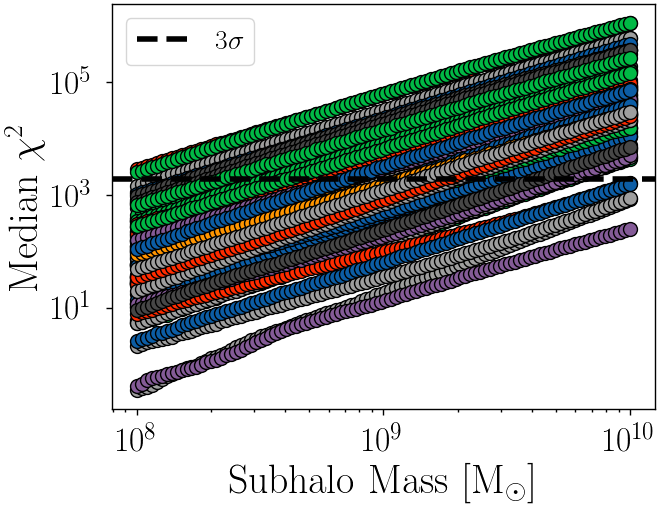

In [7]:
sample_position_key = list(results[0].keys())[0]

for i, result in enumerate(results):
    sample_results = result[sample_position_key]

    mass_list, median_list, maxes, mins = [], [], [], []
    for mass, chi_squared_list in sample_results.items():
        mass_list.append(mass)
        median_list.append(np.median(chi_squared_list))
        maxes.append(np.max(chi_squared_list))
        mins.append(np.min(chi_squared_list))
        uplims = np.array(maxes) - np.array(median_list)
        lolims = np.array(median_list) - np.array(mins)

    mass_list = [float(mass) for mass in mass_list]
    plt.errorbar(mass_list, median_list, yerr=[lolims, uplims], fmt='o')  # , label=f'Lens {i + 1}', ls='-'
plt.axhline(1950.11, color='black', linestyle='--', label=f'3$\sigma$', zorder=1e3, lw=4)
plt.xlabel('Subhalo Mass [M$_\odot$]')
plt.ylabel('Median $\chi^2$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig(os.path.join(figure_dir, 'ldsm_03_lenses.png'))
plt.show()

Skipping lens 7
Skipping lens 12
Skipping lens 19
Skipping lens 25
Skipping lens 31
Skipping lens 35
Skipping lens 36
Skipping lens 38
Skipping lens 40
Skipping lens 45
Skipping lens 56
Skipping lens 59
Skipping lens 61
Skipping lens 62
Skipping lens 63
Skipping lens 65
Skipping lens 80


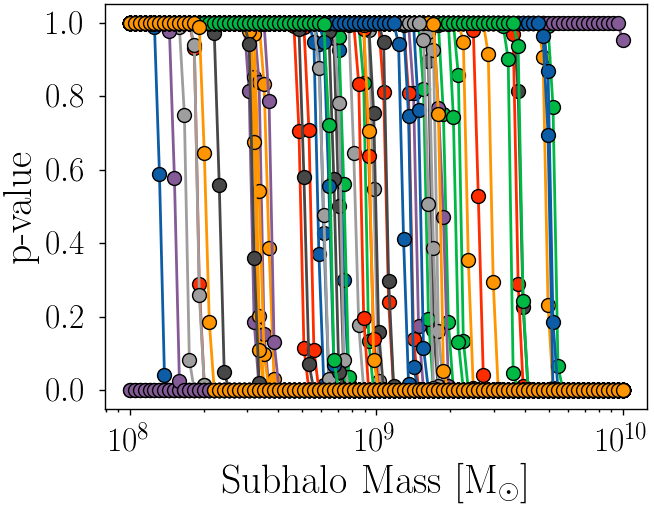

In [8]:
sample_position_key = list(results[0].keys())[0]

for i, result in enumerate(results):
    sample_results = result[sample_position_key]

    mass_list, median_list, maxes, mins = [], [], [], []
    for mass, chi_squared_list in sample_results.items():
        p_list = [rv.sf(chi) for chi in chi_squared_list]
        mass_list.append(mass)
        median_list.append(np.median(p_list))
        maxes.append(np.max(p_list))
        mins.append(np.min(p_list))
        uplims = np.array(maxes) - np.array(median_list)
        lolims = np.array(median_list) - np.array(mins)
    
    if p_list[-1] == 1.:
        print('Skipping lens', i + 1)
        results.remove(result)
        continue

    mass_list = [float(mass) for mass in mass_list]
    plt.errorbar(mass_list, median_list, yerr=[lolims, uplims], fmt='o', label=f'Lens {i + 1}', ls='-')
plt.xlabel('Subhalo Mass [M$_\odot$]')
plt.ylabel('p-value')
plt.xscale('log')
# plt.yscale('log')
# plt.legend()
plt.savefig(os.path.join(figure_dir, 'ldsm_04_p_vals.png'))
plt.show()

In [10]:
sides = 4

positions = []
for i in range(1, 19):
    sca = str(i).zfill(2)
    coords = Roman().divide_up_sca(sides)
    for coord in coords:
        positions.append((sca, coord))

masses = np.logspace(8, 10, 100)

lens_array_list = []
error_list = []

for k, result in tqdm(enumerate(results), total=len(results)):
    # print(f'Result {k + 1} of {len(results)}')
    current_sca = 1
    array_list = []

    # initialize the array and mass list
    array = np.zeros((sides, sides))
    mass_list = []

    for sca, sca_position in positions:
        position_key = f'{int(sca)}_{sca_position[0]}_{sca_position[1]}'
        position_results = result[position_key]

        for mass in masses:
            chi2_list = position_results[str(int(mass))]
            p_list = [rv.sf(chi) for chi in chi2_list]
            mass = float(mass)
            if np.min(p_list) < pval_threshold:
                # print(f'hit threshold at {mass:.2e}')
                mass_list.append(mass)
                break

        # if the last position has been reached, populate the array with the masses
        if sca_position == coords[-1]:  
            for i in range(sides):
                for j in range(sides):
                    try:
                        array[i, j] = mass_list[j * sides + i]
                    except Exception as e:
                        error_list.append(k)
                        # print(k)
            array_list.append(array)

            # reset the array and mass list
            array = np.zeros((sides, sides))
            mass_list = []
    
    lens_array_list.append(array_list)

print(error_list)
# plt.imshow(array_list[0], cmap='viridis')
# plt.colorbar()
# plt.show()

  0%|          | 0/83 [00:00<?, ?it/s]

100%|██████████| 83/83 [04:25<00:00,  3.20s/it]

[47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,

In [12]:
for k, result in tqdm(enumerate(results), total=len(results)):
    if k in error_list:
        print(f'Skipping lens {k + 1}')
        continue
    # else:
        # print(f'Result {k + 1} of {len(results)}')
    current_sca = 1
    array_list = []

    # initialize the array and mass list
    array = np.zeros((sides, sides))
    mass_list = []

    for sca, sca_position in positions:
        position_key = f'{int(sca)}_{sca_position[0]}_{sca_position[1]}'
        position_results = result[position_key]

        for mass in masses:
            chi2_list = position_results[str(int(mass))]
            p_list = [rv.sf(chi) for chi in chi2_list]
            mass = float(mass)
            if np.min(p_list) < pval_threshold:
                # print(f'hit threshold at {mass:.2e}')
                mass_list.append(mass)
                break

        # if the last position has been reached, populate the array with the masses
        if sca_position == coords[-1]:  
            for i in range(sides):
                for j in range(sides):
                    try:
                        array[i, j] = mass_list[j * sides + i]
                    except Exception as e:
                        error_list.append(k)
                        print(k)
            array_list.append(array)

            # reset the array and mass list
            array = np.zeros((sides, sides))
            mass_list = []
    
    lens_array_list.append(array_list)

 57%|█████▋    | 47/83 [02:27<01:53,  3.14s/it]

Skipping lens 48


 71%|███████   | 59/83 [03:04<01:18,  3.29s/it]

Skipping lens 60
Skipping lens 61


 75%|███████▍  | 62/83 [03:08<00:47,  2.26s/it]

Skipping lens 63


 94%|█████████▍| 78/83 [04:08<00:18,  3.72s/it]

Skipping lens 79


100%|██████████| 83/83 [04:17<00:00,  3.11s/it]


In [13]:
# for i, _ in enumerate(results):
#     plotting.roman_sca_plot(np.asarray(lens_array_list[i]), 
#                             np.asarray(range(1, 19)), 
#                             residual_plot=False, 
#                             show_sca_id=False, 
#                             cmap='viridis_r', 
#                             savefig=False, 
#                             savepath=None,  # os.path.join(figure_dir, 'lowest_detectable_subhalo_mass_single_system.png') 
#                             clabel=r'Lowest detectable subhalo mass [M$_\odot$]')

In [18]:
median_array_list = []

for sca in range(1, 19):
    array = np.zeros((sides, sides))

    for i in range(sides):
            for j in range(sides):
                pixel_values = []
                for lens_array in lens_array_list:
                    pixel_values.append(lens_array[sca - 1][i, j])
                median = np.mean(pixel_values)
                array[i, j] = median
    
    median_array_list.append(array)

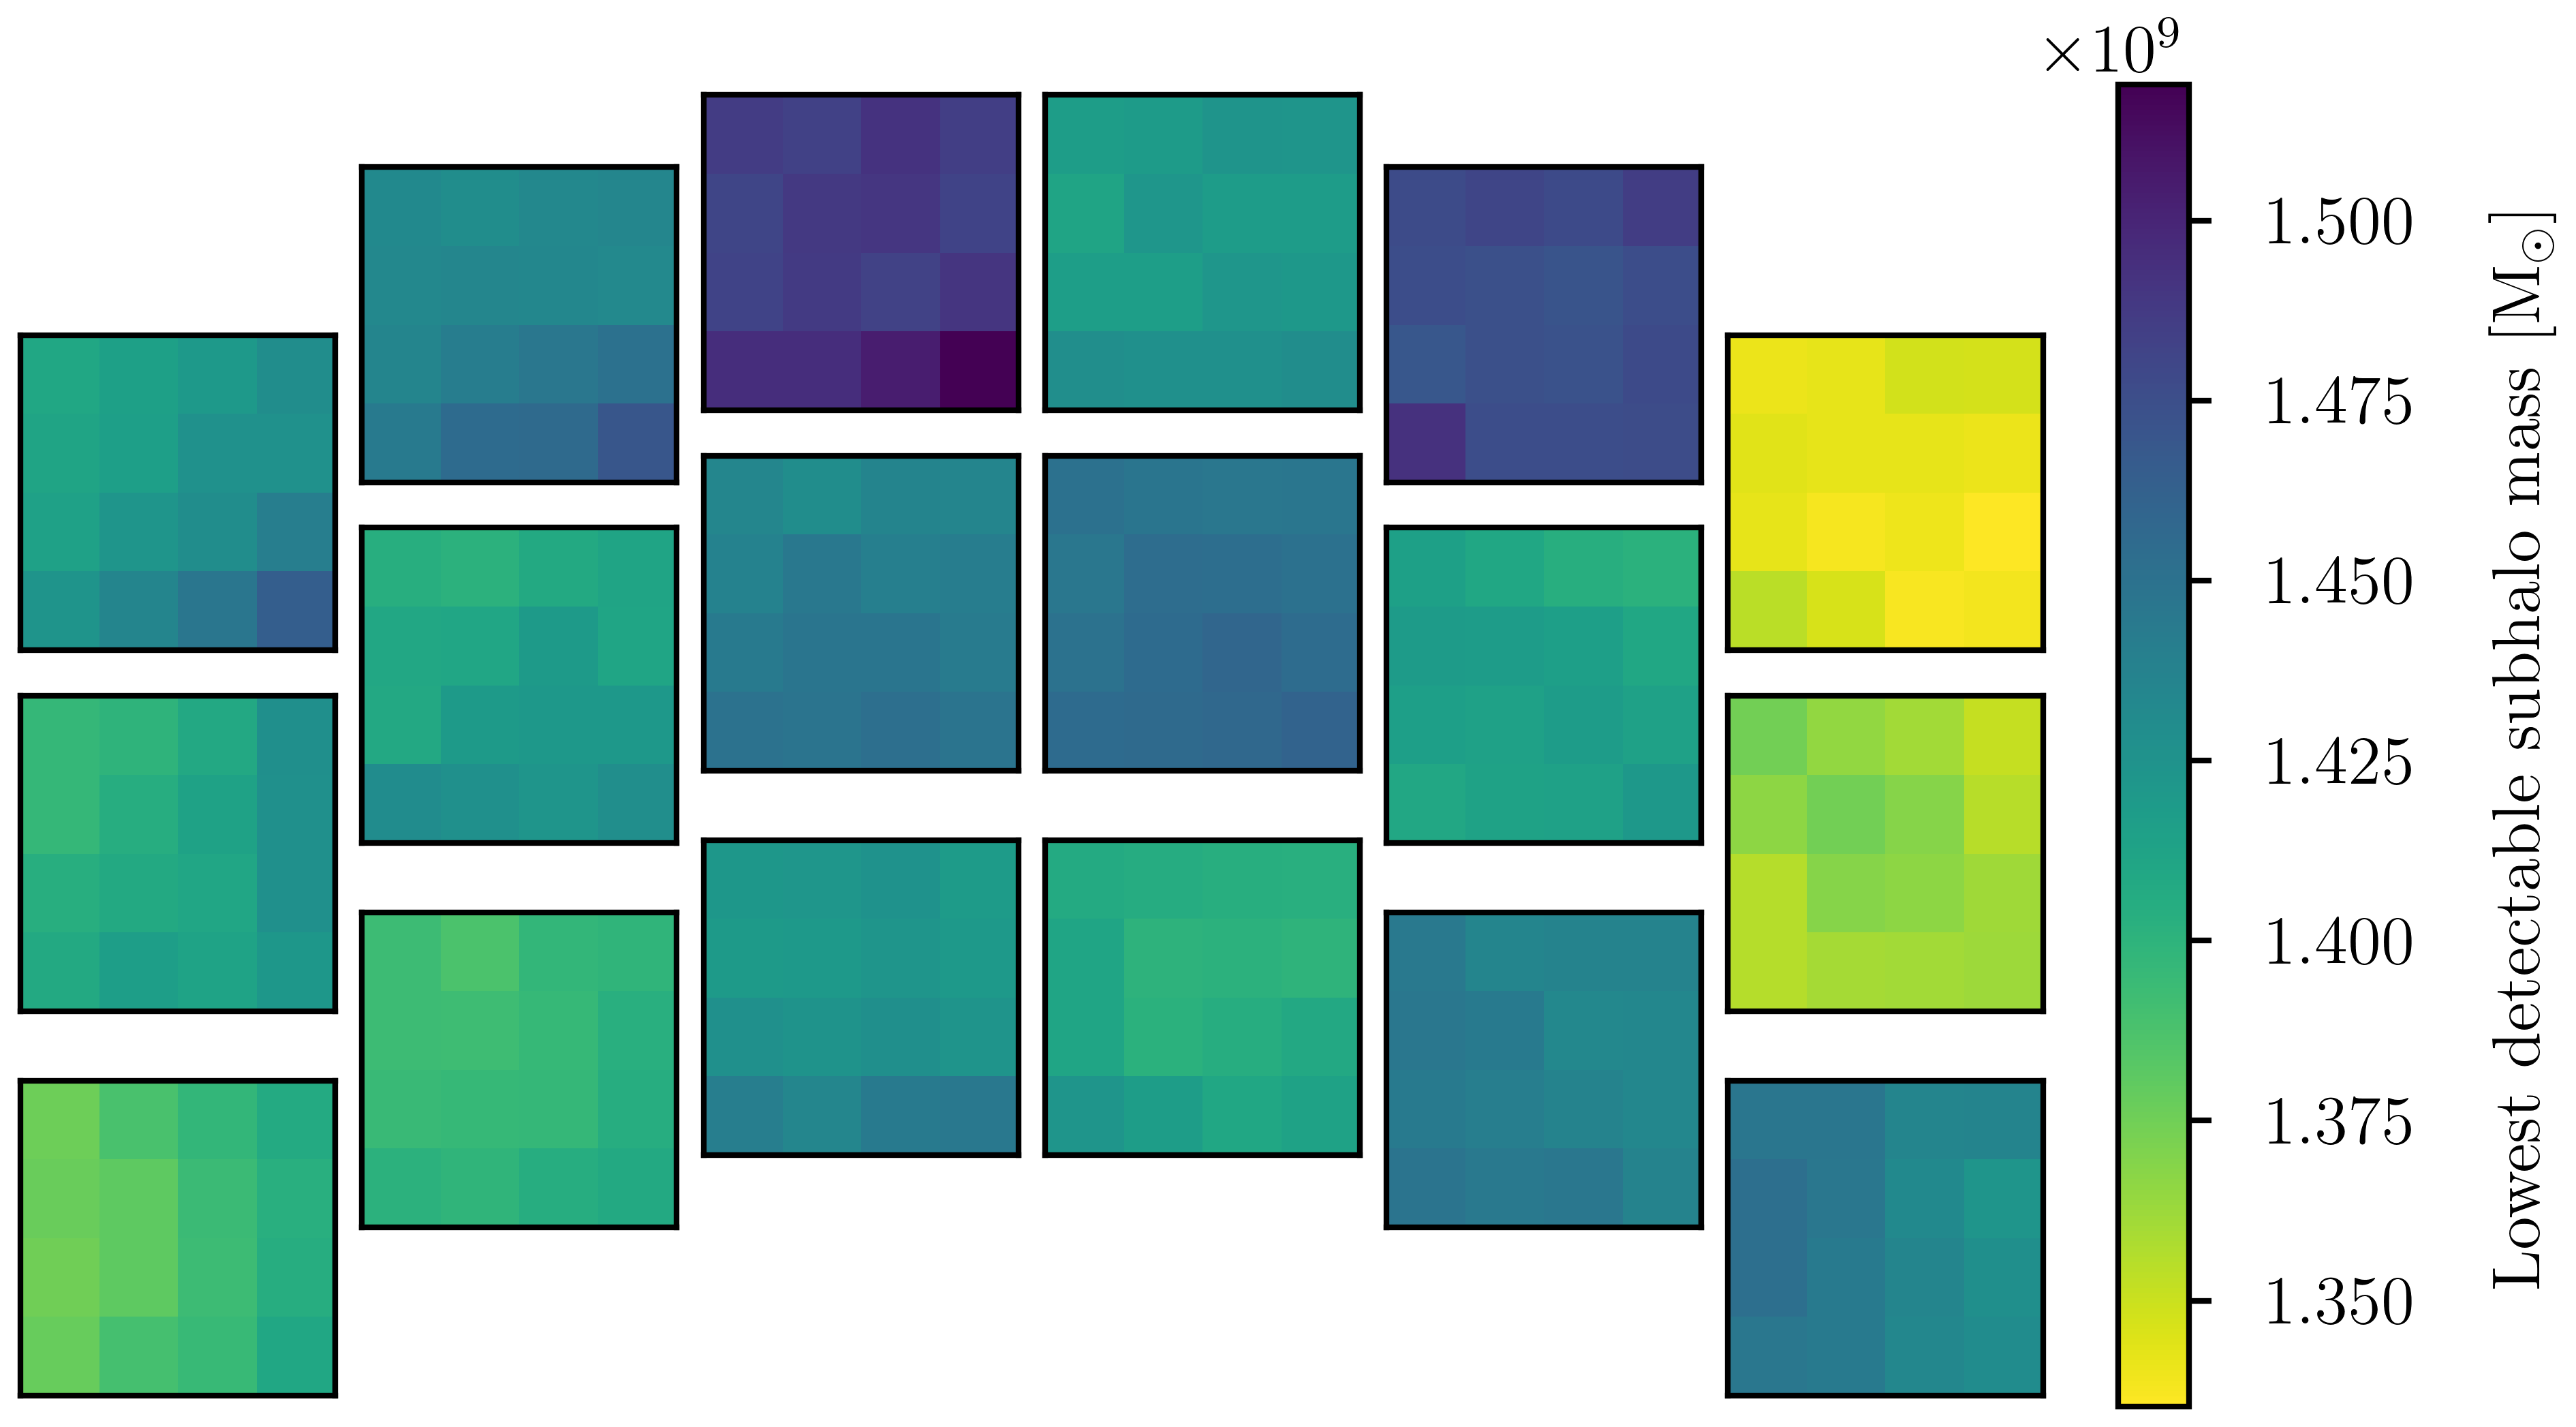

In [19]:
plotting.roman_sca_plot(np.asarray(median_array_list), 
                        np.asarray(range(1, 19)), 
                        residual_plot=False, 
                        show_sca_id=False, 
                        cmap='viridis_r', 
                        savefig=True, 
                        savepath=os.path.join(figure_dir, 'lowest_detectable_subhalo_mass.png'), 
                        clabel=r'Lowest detectable subhalo mass [M$_\odot$]')